## Project: **Finding Lane Lines on the Road** 

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

## Reading an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


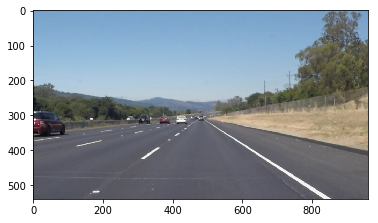

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Importing all the images

In [3]:
test_img_dir = "test_images/"
original_image_names = os.listdir(test_img_dir)
original_image_names = list(map(lambda name: test_img_dir + name, original_image_names))
original_images = list(map(lambda img_name: mpimg.imread(img_name), original_image_names))
img_shape = original_images[0].shape

In [4]:
def show_image_list(img_list, cols=2, fig_size=(15, 15), img_labels=original_image_names, show_ticks=True):
    img_count = len(img_list)
    rows = img_count / cols
    cmap = None
    plt.figure(figsize=fig_size)
    for i in range(0, img_count):
        img_name = img_labels[i]
        
        plt.subplot(rows, cols, i+1)
        img = img_list[i]
        if len(img.shape) < 3:
            cmap = "gray"
        
        if not show_ticks:
            plt.xticks([])
            plt.yticks([])
            
        plt.title(img_name[len(test_img_dir):])    
        plt.imshow(img, cmap=cmap)

    plt.tight_layout()
    plt.show()

## Pipeline

The pipeline will consist of the following steps
    * Convert image to HSL
    * Isolate yellow and white regions from image
    * Grayscale
    * Gaussian Blur
    * Canny Edge Detection
    * Clipping Region Of Interest
    * Hough Transform
    * Separate left and right lanes
    * Extrapolate them to create two smooth lines

### Step 1: Convert to HSL
Visualising the current RGB image in the HSL color space helps us isolate the lanes better
H stands for Hue, S stands for saturation and L stands for Lightness, is not the same as Brightness/Value. Brightness is perceived as the "amount of light" which can be any color while Lightness is best understood as the amount of white.


In [5]:
def to_hsl(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

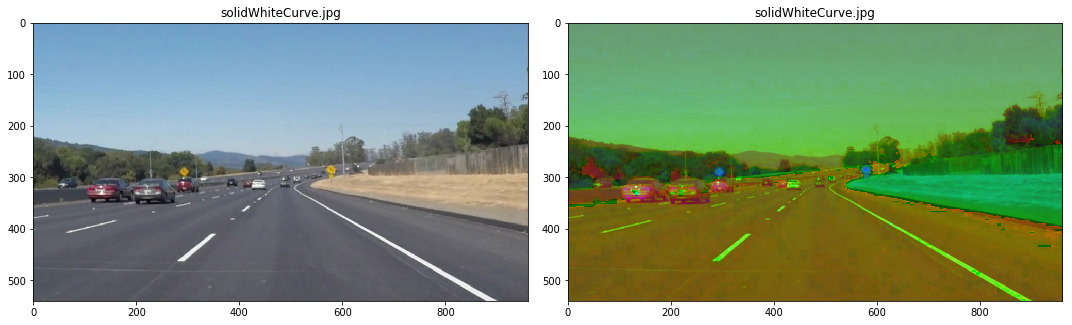

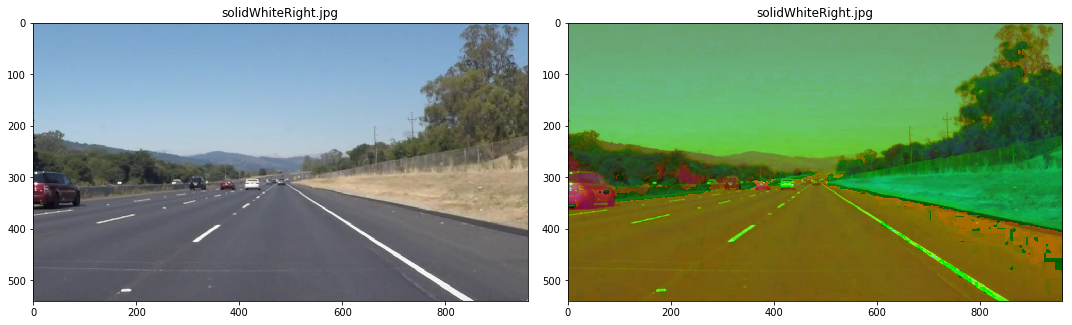

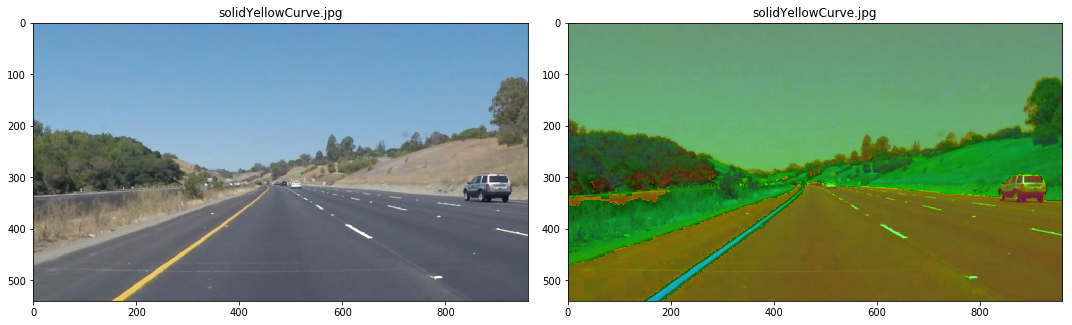

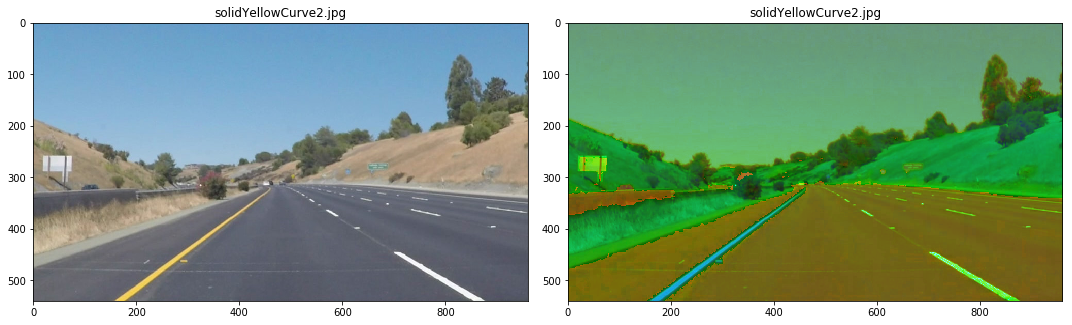

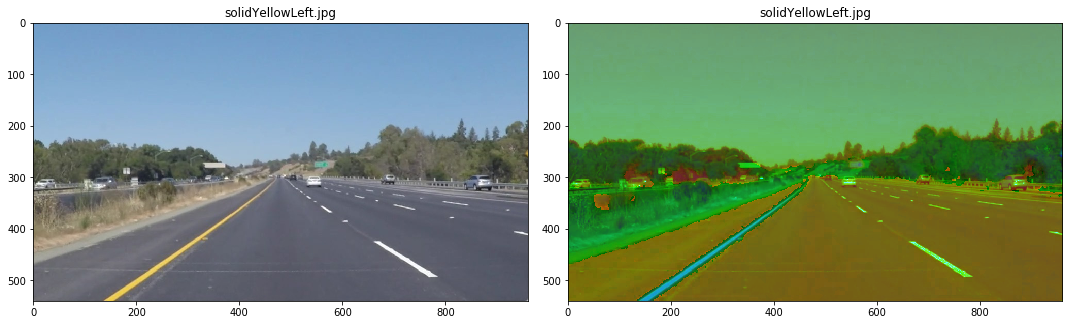

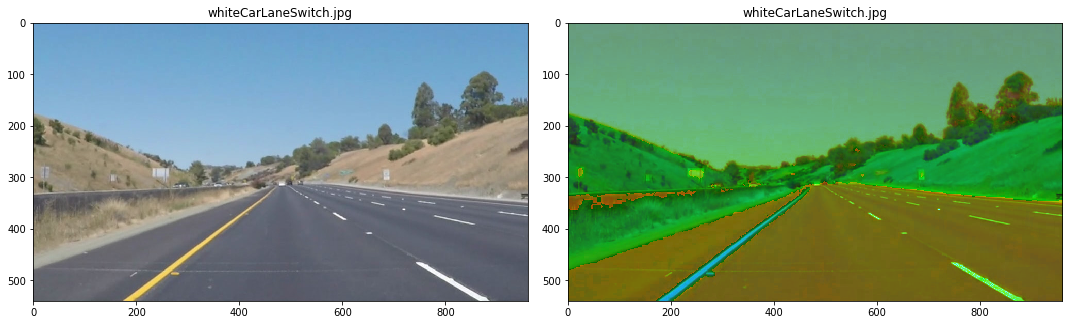

In [6]:
hsl_images = list(map(lambda img: to_hsl(img), original_images))
img_count = len(hsl_images)
interleaved_hsx = list(zip(original_images, hsl_images))

k = 0
for hsx in interleaved_hsx:
    img_name = original_image_names[k]
    show_image_list(hsx, cols=2, fig_size=(15, 15), img_labels=[img_name, img_name, img_name] )
    k += 1

### Step 2: Extracting Yellow and White from the image

In [7]:
def isolate_yellow_hsl(img):
    low_threshold = np.array([15, 38, 115], dtype=np.uint8)
    high_threshold = np.array([35, 204, 255], dtype=np.uint8)  
    yellow_mask = cv2.inRange(img, low_threshold, high_threshold)
    return yellow_mask

def isolate_white_hsl(img):
    low_threshold = np.array([0, 200, 0], dtype=np.uint8)
    high_threshold = np.array([180, 255, 255], dtype=np.uint8)
    yellow_mask = cv2.inRange(img, low_threshold, high_threshold)
    return yellow_mask

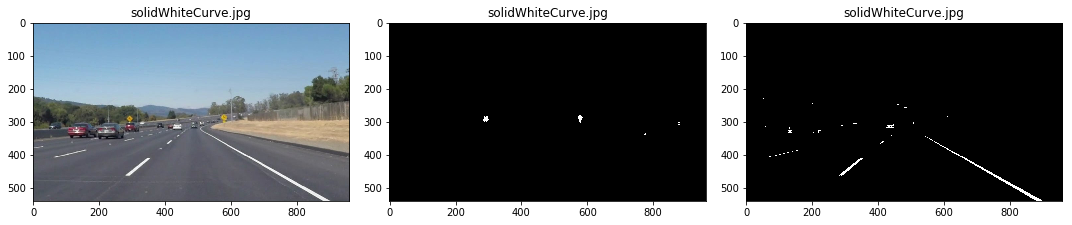

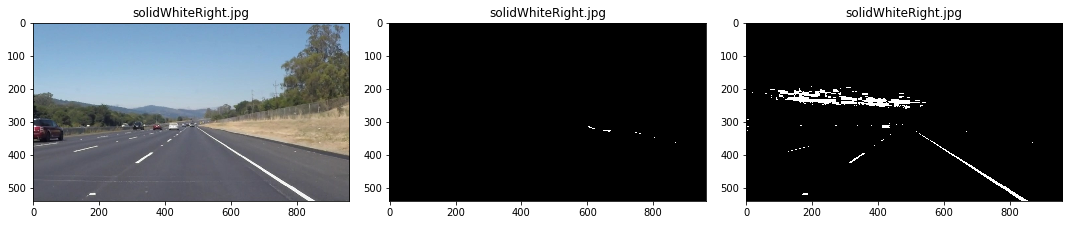

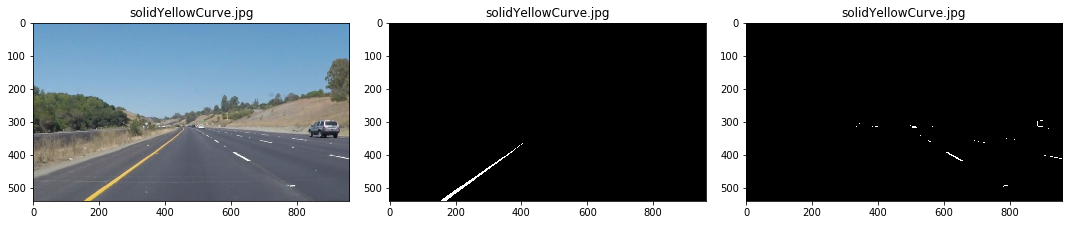

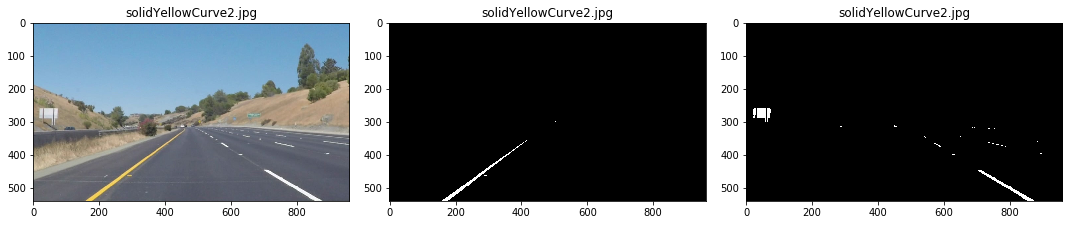

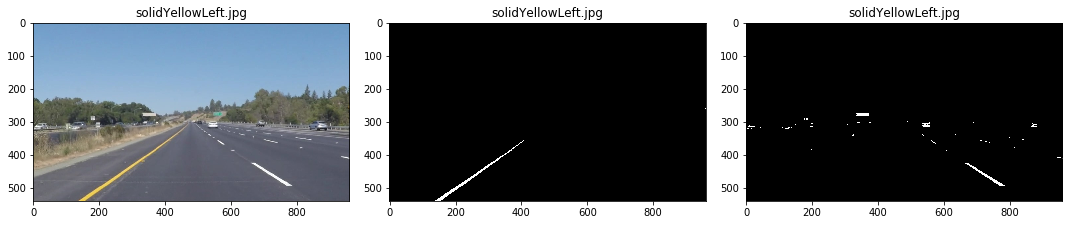

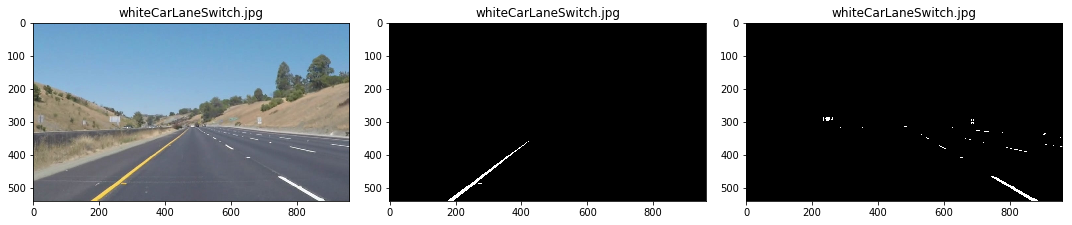

In [8]:
hsl_yellow_images = list(map(lambda img: isolate_yellow_hsl(img), hsl_images))
hsl_white_images = list(map(lambda img: isolate_white_hsl(img), hsl_images))

img_count = len(hsl_images)
interleaved_isolated_hsl = list(zip(original_images, hsl_yellow_images, hsl_white_images))

k = 0
for isolated_hsl in interleaved_isolated_hsl:
    img_name = original_image_names[k]
    show_image_list(isolated_hsl, cols=3, fig_size=(15, 15), img_labels=[img_name, img_name, img_name] )
    k += 1

You can see yellow extracted from the image in the 2nd column and white in the 3rd column. Let's now combine those two masks using an OR operation and then combine with the original image using an AND operation to only retain the intersecting elements.

In [9]:
def combine_hsl_isolated_with_original(img, hsl_yellow, hsl_white):
    hsl_mask = cv2.bitwise_or(hsl_yellow, hsl_white)
    return cv2.bitwise_and(img, img, mask=hsl_mask)

def filter_img_hsl(img):
    hsl_img = to_hsl(img)
    hsl_yellow = isolate_yellow_hsl(hsl_img)
    hsl_white = isolate_white_hsl(hsl_img)
    return combine_hsl_isolated_with_original(img, hsl_yellow, hsl_white)

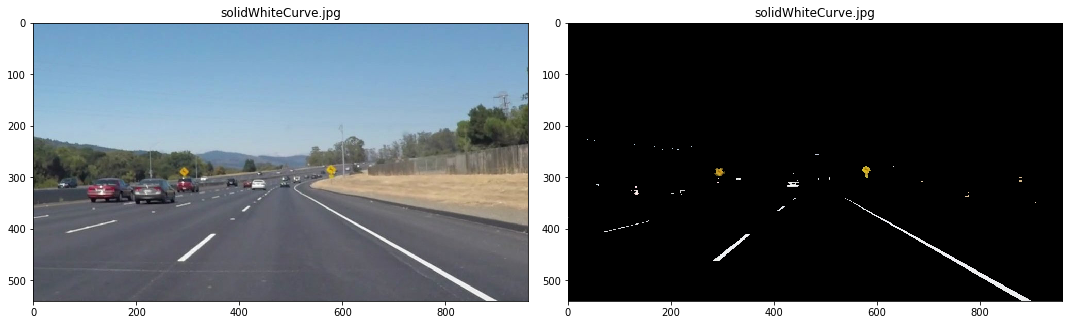

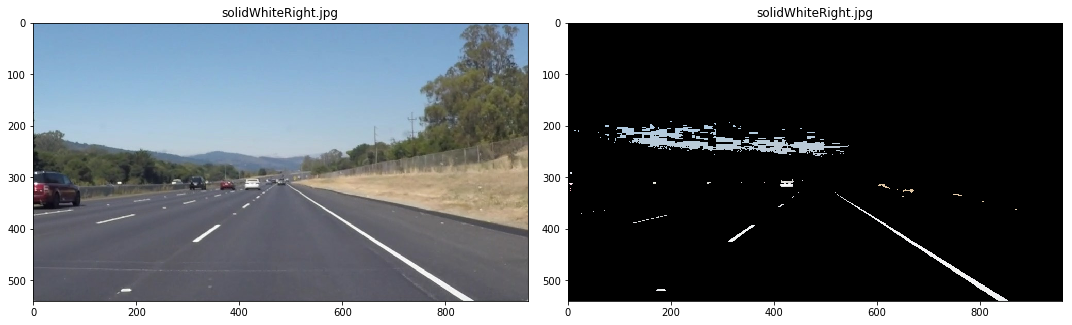

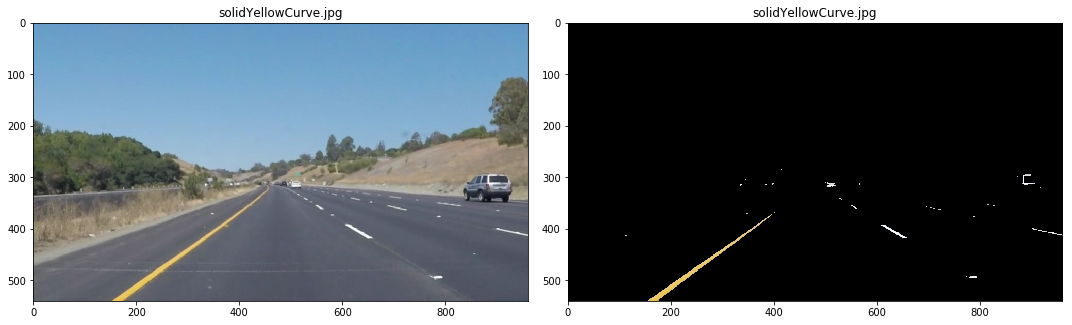

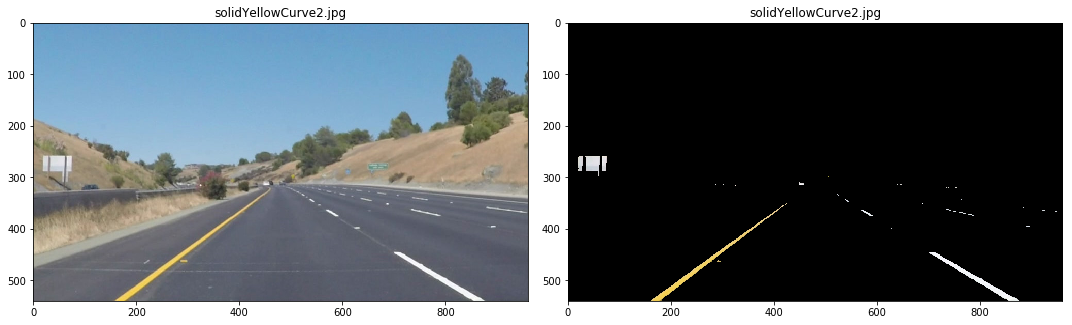

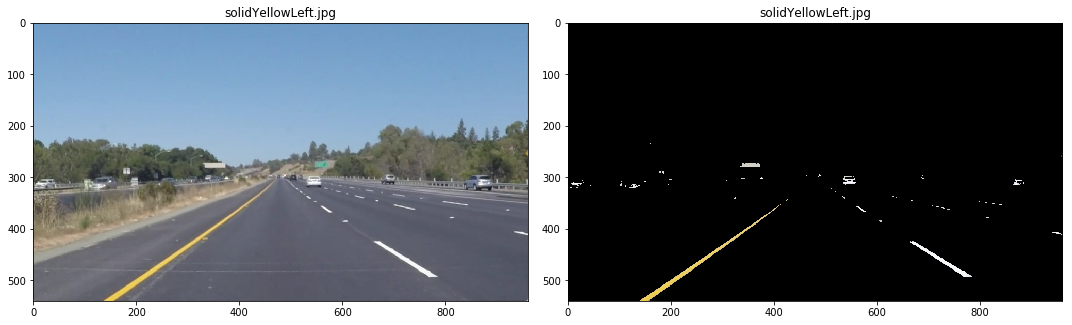

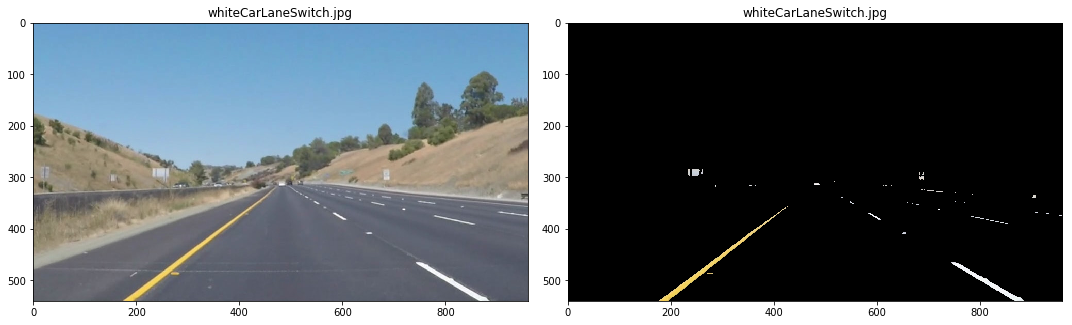

In [10]:
combined_hsl_images = hsl_images = list(map(lambda img: filter_img_hsl(img), original_images))
img_count = len(combined_hsl_images)
interleaved_combined_hsl = list(zip(original_images, combined_hsl_images))

k = 0
for combined_hsl in interleaved_combined_hsl:
    img_name = original_image_names[k]
    show_image_list(combined_hsl, cols=2, fig_size=(15, 15), img_labels=[img_name, img_name] )
    k += 1

### Step 3: Converting to Grayscale

Anything that is much brighter on the road will come out with a high contrast in a grayscale image

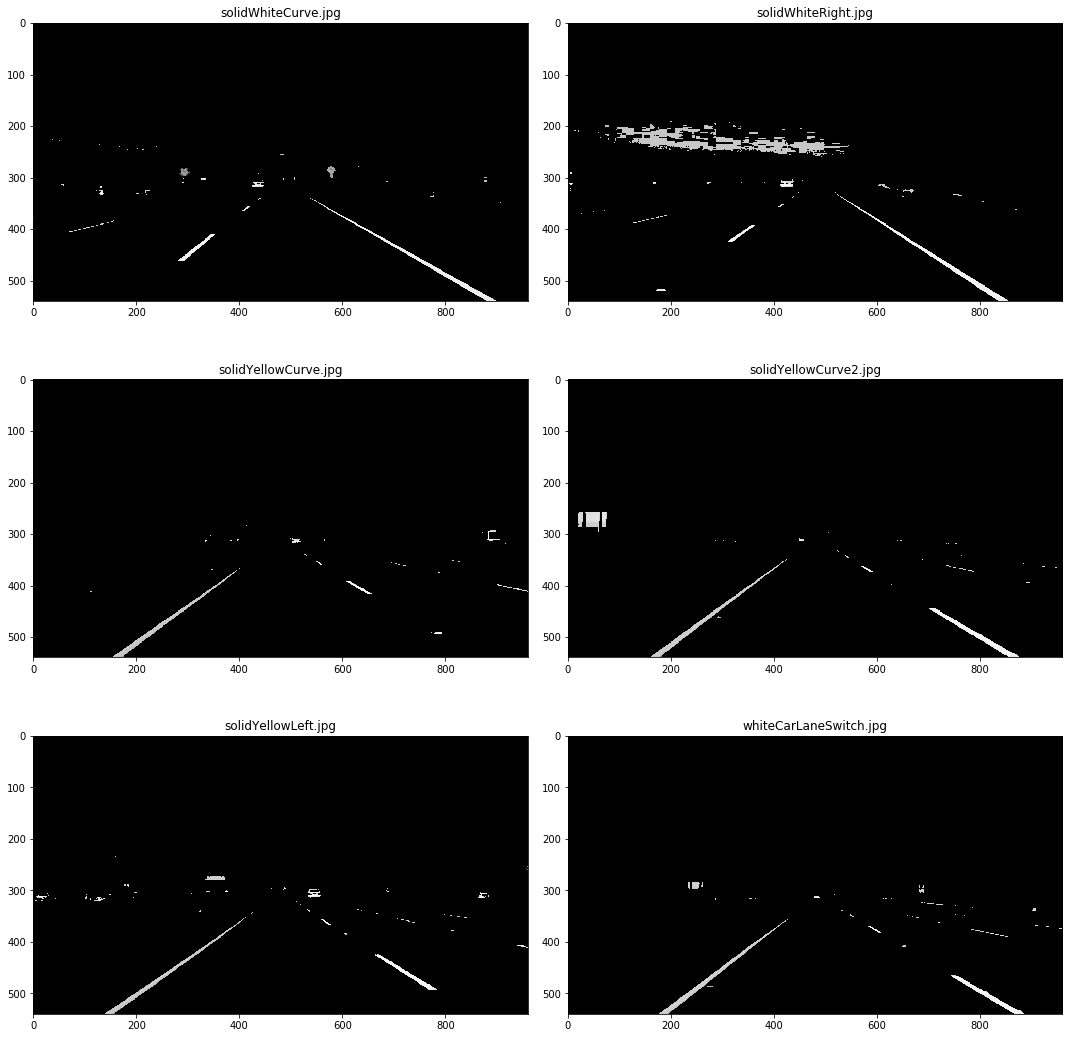

In [11]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
grayscale_images = list(map(lambda img: grayscale(img), combined_hsl_images))
show_image_list(grayscale_images)

### Step 4: Apply Gausian Blur

On the left is the grayscale of the original image and on the right is the grayscale of the HSL image

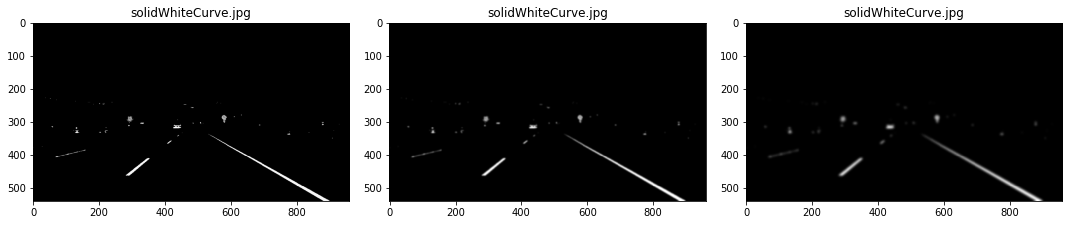

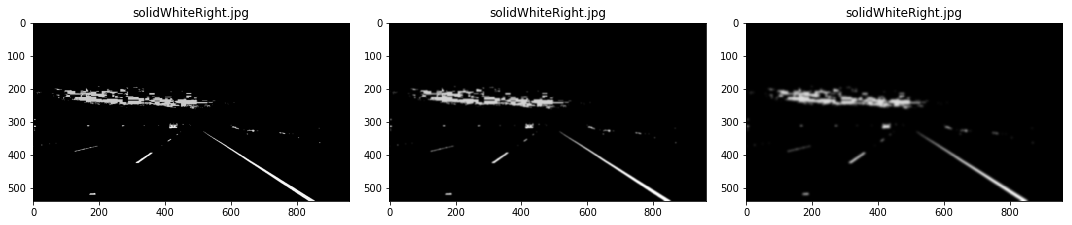

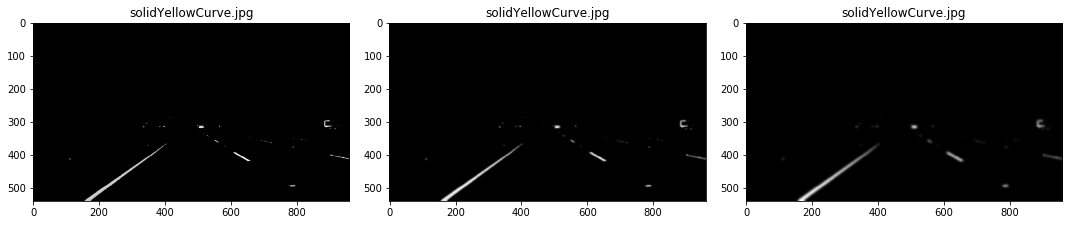

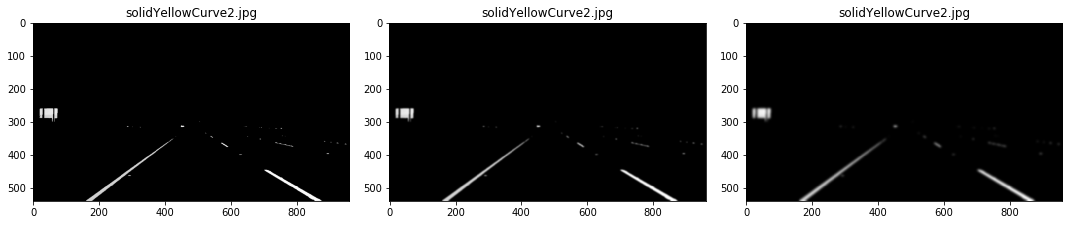

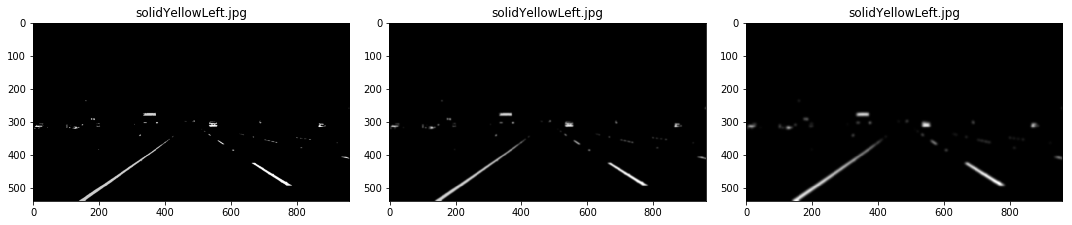

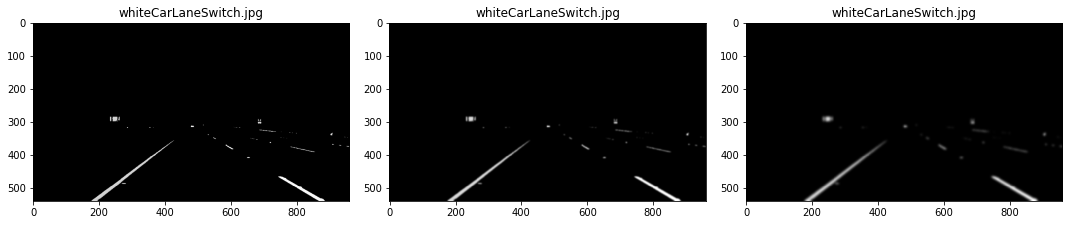

In [12]:
def gaussian_blur(grayscale_img, kernel_size=3):
    return cv2.GaussianBlur(grayscale_img, (kernel_size, kernel_size), 0)

blurred_images1 = list(map(lambda img: gaussian_blur(img, kernel_size=5), grayscale_images))
blurred_images2 = list(map(lambda img: gaussian_blur(img, kernel_size=11), grayscale_images))
blurred_images3 = list(map(lambda img: gaussian_blur(img, kernel_size=21), grayscale_images))

img_count = len(blurred_images1)
interleaved_blur = list(zip(blurred_images1, blurred_images2, blurred_images3))

k = 0
for blurs in interleaved_blur:
    img_name = original_image_names[k]
    show_image_list(blurs, cols=3, fig_size=(15, 15), img_labels=[img_name, img_name, img_name] )
    k += 1

As you can see, higher the kernel size higher is the amount of blur

### Step 5: Canny Edge Detection

As the name suggests it detects edges in the image and discards rest of the information

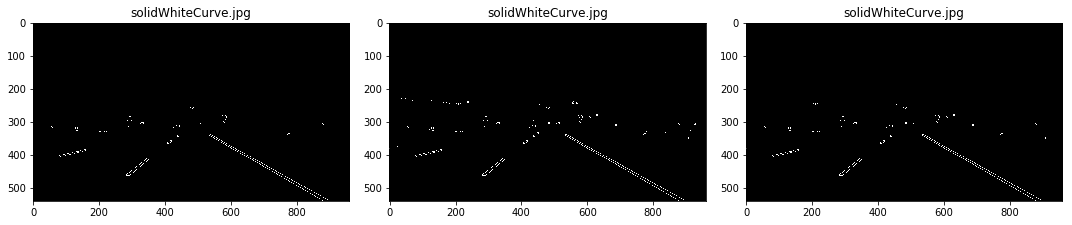

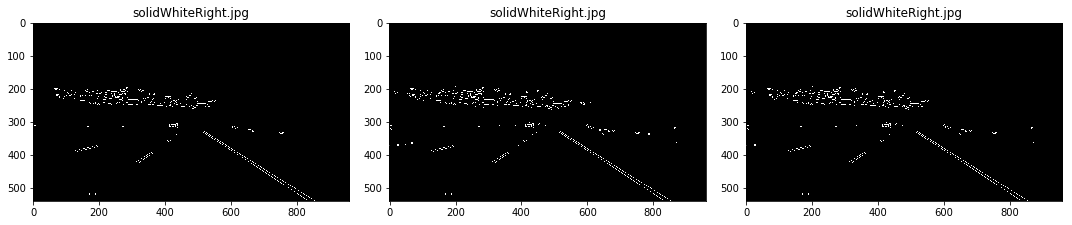

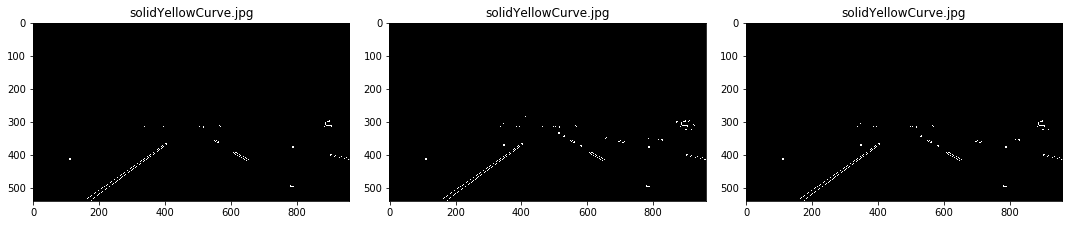

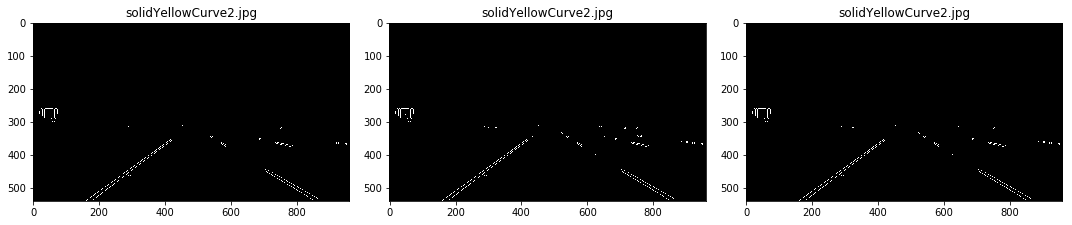

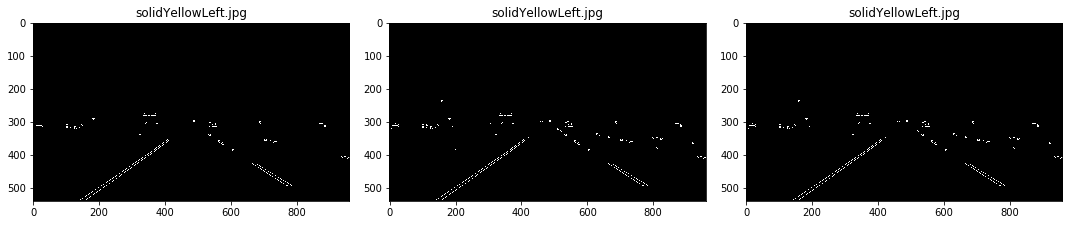

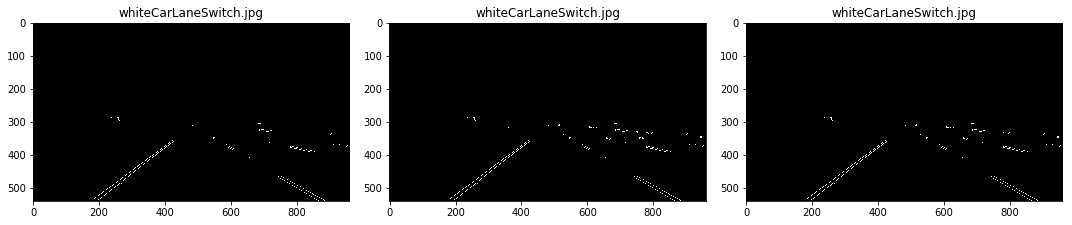

In [13]:
def canny_edge_detector(blurred_img, low_threshold, high_threshold):
    return cv2.Canny(blurred_img, low_threshold, high_threshold)

canny_images1 = list(map(lambda img: canny_edge_detector(img, 50, 150), blurred_images2)) 
canny_images2 = list(map(lambda img: canny_edge_detector(img, 0, 10), blurred_images2)) 
canny_images3 = list(map(lambda img: canny_edge_detector(img, 10, 50), blurred_images2))

img_count = len(canny_images1)
interleaved_canny = list(zip(canny_images1, canny_images2, canny_images3))

k = 0
for cannys in interleaved_canny:
    img_name = original_image_names[k]
    show_image_list(cannys, cols=3, fig_size=(15, 15), img_labels=[img_name, img_name, img_name])
    k += 1

I'll go with images on the left as they are least noisy

### Step 6: Clipping Region of Interest

In [14]:
def get_vertices_for_img(img):
    imshape = img.shape
    height = imshape[0]
    width = imshape[1]

    vert = None
    
    if (width, height) == (960, 540):
        region_bottom_left = (130 ,img_shape[0] - 1)
        region_top_left = (410, 330)
        region_top_right = (650, 350)
        region_bottom_right = (img_shape[1] - 30,img_shape[0] - 1)
        vert = np.array([[region_bottom_left , region_top_left, region_top_right, region_bottom_right]], dtype=np.int32)
    else:
        region_bottom_left = (200 , 680)
        region_top_left = (600, 450)
        region_top_right = (750, 450)
        region_bottom_right = (1100, 650)
        vert = np.array([[region_bottom_left , region_top_left, region_top_right, region_bottom_right]], dtype=np.int32)

    return vert

def region_of_interest(img):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
        
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    vert = get_vertices_for_img(img)    
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vert, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

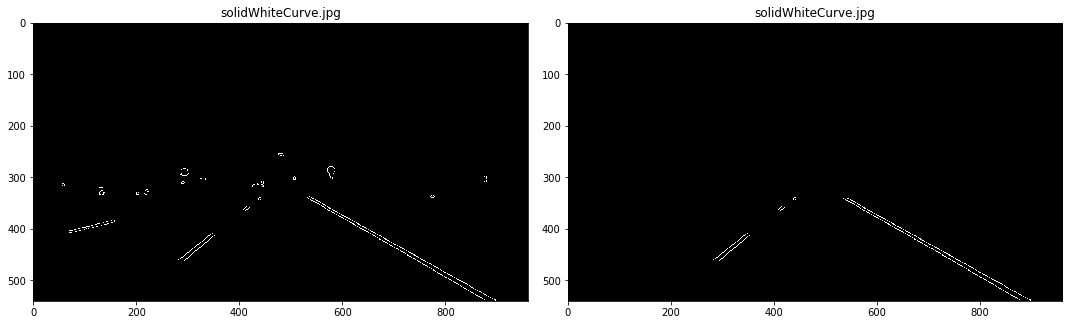

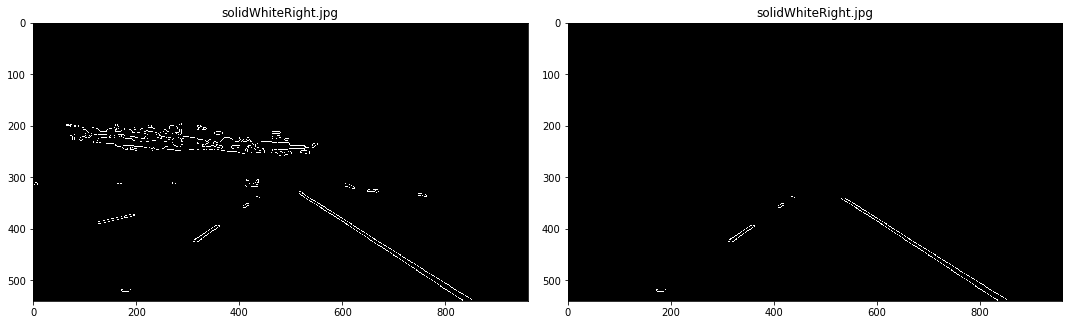

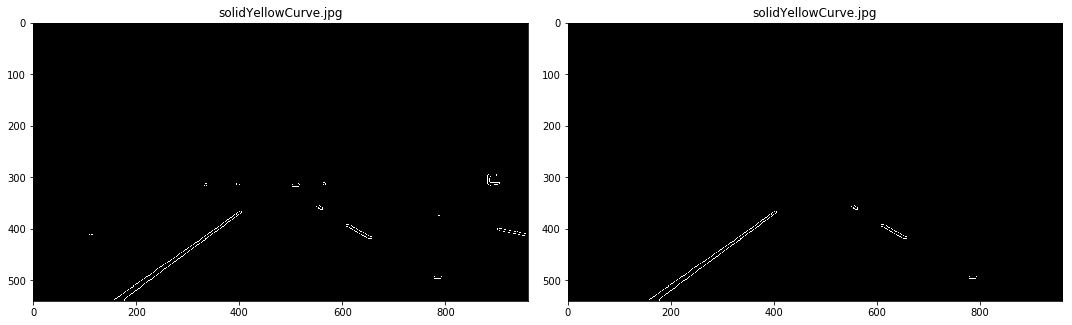

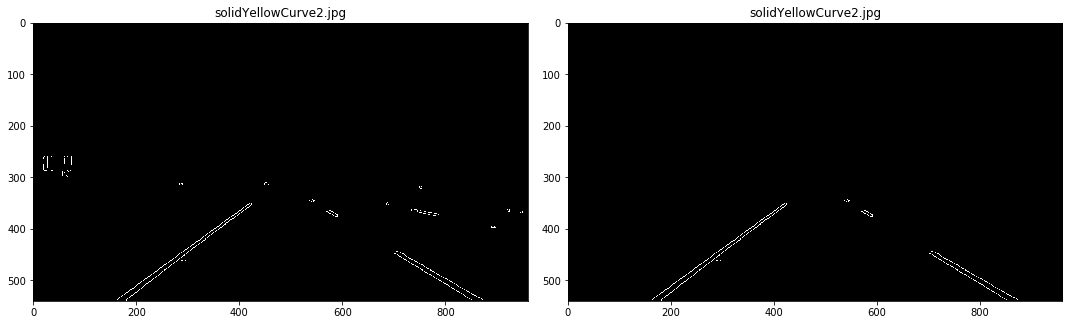

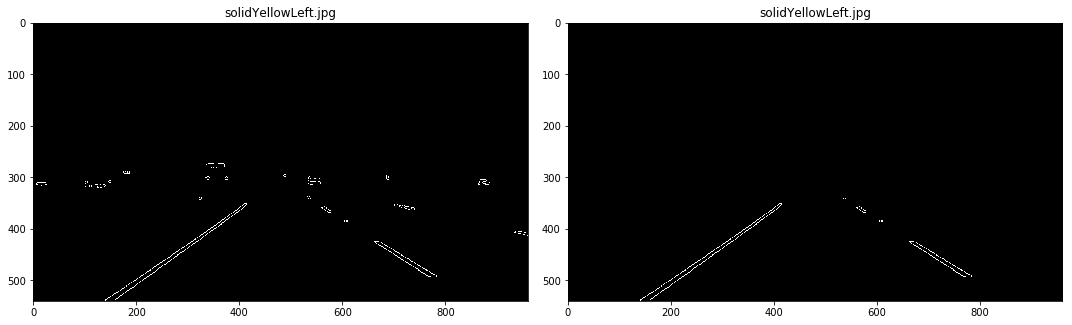

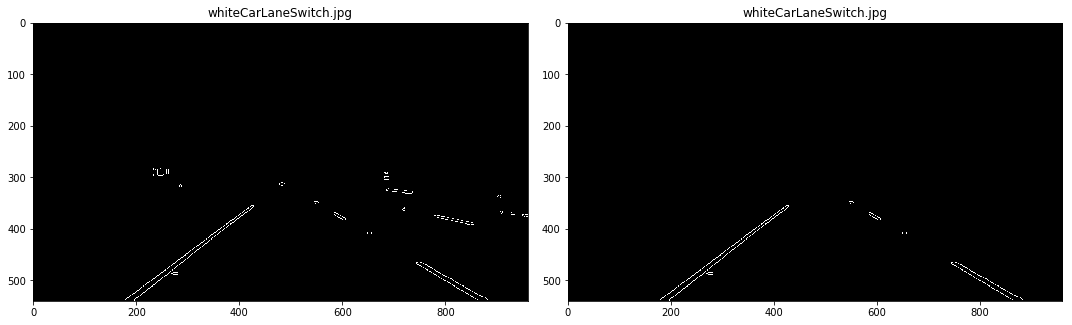

In [15]:
segmented_images = list(map(lambda img: region_of_interest(img), canny_images1))
canny_segmented_images = list(zip(canny_images1, segmented_images))

k = 0
for canny_segmented_img in canny_segmented_images: 
    img_name = original_image_names[k]
    show_image_list(canny_segmented_img, img_labels=[img_name, img_name])
    k += 1

### Step 7: Applying Hough Transform

Hough Transform finds lines by tracing points that lie on them. It achieves that by transforming cartesian space (x,y) to hough space (m,b)

In [16]:
def hough_transform(canny_img, rho, theta, threshold, min_line_len, max_line_gap):
    return cv2.HoughLinesP(canny_img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
rho = 1
# 1 degree
theta = (np.pi/180) * 1
threshold = 15
min_line_length = 20
max_line_gap = 10
hough_lines_per_image = list(map(lambda img: hough_transform(img, rho, theta, threshold, min_line_length, max_line_gap), 
                                 segmented_images))

### Step 8: Differentiating Left and Right Lanes

In [17]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=10, make_copy=True):
    # Copy the passed image
    img_copy = np.copy(img) if make_copy else img
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img_copy, (x1, y1), (x2, y2), color, thickness)
    
    return img_copy

You can calculate the slope to find if the lane is on the right or on the left
* left lane: as x value (i.e. width) increases, y value (i.e. height) decreases: slope must thus be negative
* right lane:as x value (i.e. width) increases, y value (i.e. height) increases: slope must thus be positive

In [18]:
def separate_lines(lines, img):
    img_shape = img.shape
    
    middle_x = img_shape[1] / 2
    
    left_lane_lines = []
    right_lane_lines = []

    for line in lines:
        for x1, y1, x2, y2 in line:
            dx = x2 - x1 
            if dx == 0:
                #Discarding line since we can't gradient is undefined at this dx
                continue
            dy = y2 - y1
            
            # Similarly, if the y value remains constant as x increases, discard line
            if dy == 0:
                continue
            
            slope = dy / dx
            
            # This is pure guess than anything... 
            # but get rid of lines with a small slope as they are likely to be horizontal one
            epsilon = 0.1
            if abs(slope) <= epsilon:
                continue
            
            if slope < 0 and x1 < middle_x and x2 < middle_x:
                # Lane should also be within the left hand side of region of interest
                left_lane_lines.append([[x1, y1, x2, y2]])
            elif x1 >= middle_x and x2 >= middle_x:
                # Lane should also be within the right hand side of region of interest
                right_lane_lines.append([[x1, y1, x2, y2]])
    
    return left_lane_lines, right_lane_lines

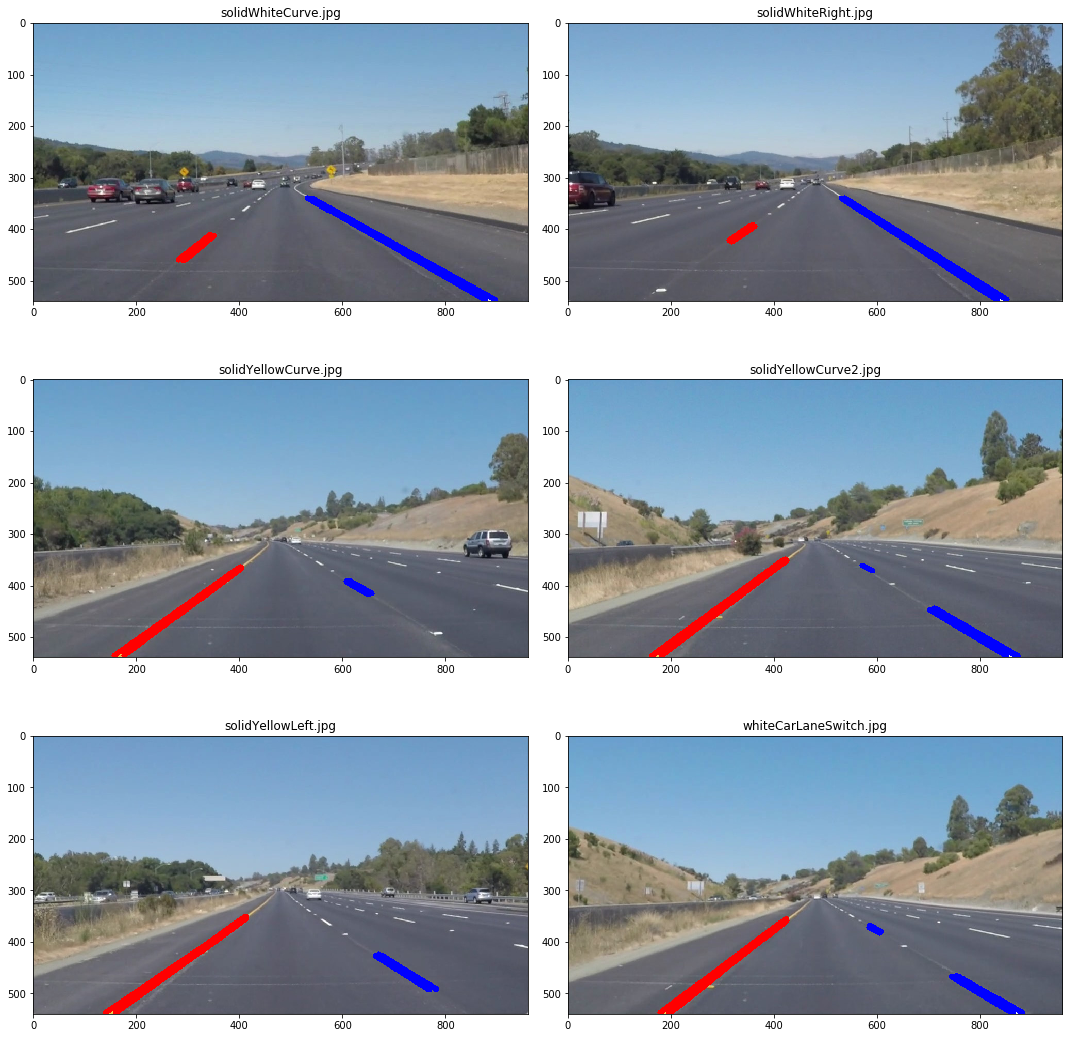

In [19]:
separated_lanes_per_image = list(map(lambda lines, img: separate_lines(lines, img), hough_lines_per_image, original_images))
def color_lanes(img, left_lane_lines, right_lane_lines, left_lane_color=[255, 0, 0], right_lane_color=[0, 0, 255]):
    left_colored_img = draw_lines(img, left_lane_lines, color=left_lane_color, make_copy=True)
    right_colored_img = draw_lines(left_colored_img, right_lane_lines, color=right_lane_color, make_copy=False)
    
    return right_colored_img

img_different_lane_colors = list(map(lambda img, separated_lanes: color_lanes(img, separated_lanes[0], separated_lanes[1]), original_images, separated_lanes_per_image))
show_image_list(img_different_lane_colors)

### Step 9: Extrapolating the straight lines

We perform linear regression to find a straight line for both the lanes

In [20]:
from scipy import stats

def find_lane_lines_formula(lines):
    xs = []
    ys = []
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            xs.append(x1)
            xs.append(x2)
            ys.append(y1)
            ys.append(y2)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(xs, ys)
    return (slope, intercept)

In [21]:
def trace_lane_line(img, lines, top_y, make_copy=True):
    A, b = find_lane_lines_formula(lines)
    vert = get_vertices_for_img(img)

    img_shape = img.shape
    bottom_y = img_shape[0] - 1
    # y = Ax + b, therefore x = (y - b) / A
    x_to_bottom_y = (bottom_y - b) / A
    
    top_x_to_y = (top_y - b) / A 
    
    new_lines = [[[int(x_to_bottom_y), int(bottom_y), int(top_x_to_y), int(top_y)]]]
    return draw_lines(img, new_lines, make_copy=make_copy)

def trace_both_lane_lines(img, left_lane_lines, right_lane_lines):
    vert = get_vertices_for_img(img)
    region_top_left = vert[0][1]
    
    full_left_lane_img = trace_lane_line(img, left_lane_lines, region_top_left[1], make_copy=True)
    full_left_right_lanes_img = trace_lane_line(full_left_lane_img, right_lane_lines, region_top_left[1], make_copy=False)
    
    # image1 * α + image2 * β + λ
    # image1 and image2 must be the same shape.
    img_with_lane_weight =  cv2.addWeighted(img, 0.7, full_left_right_lanes_img, 0.3, 0.0)
    
    return img_with_lane_weight

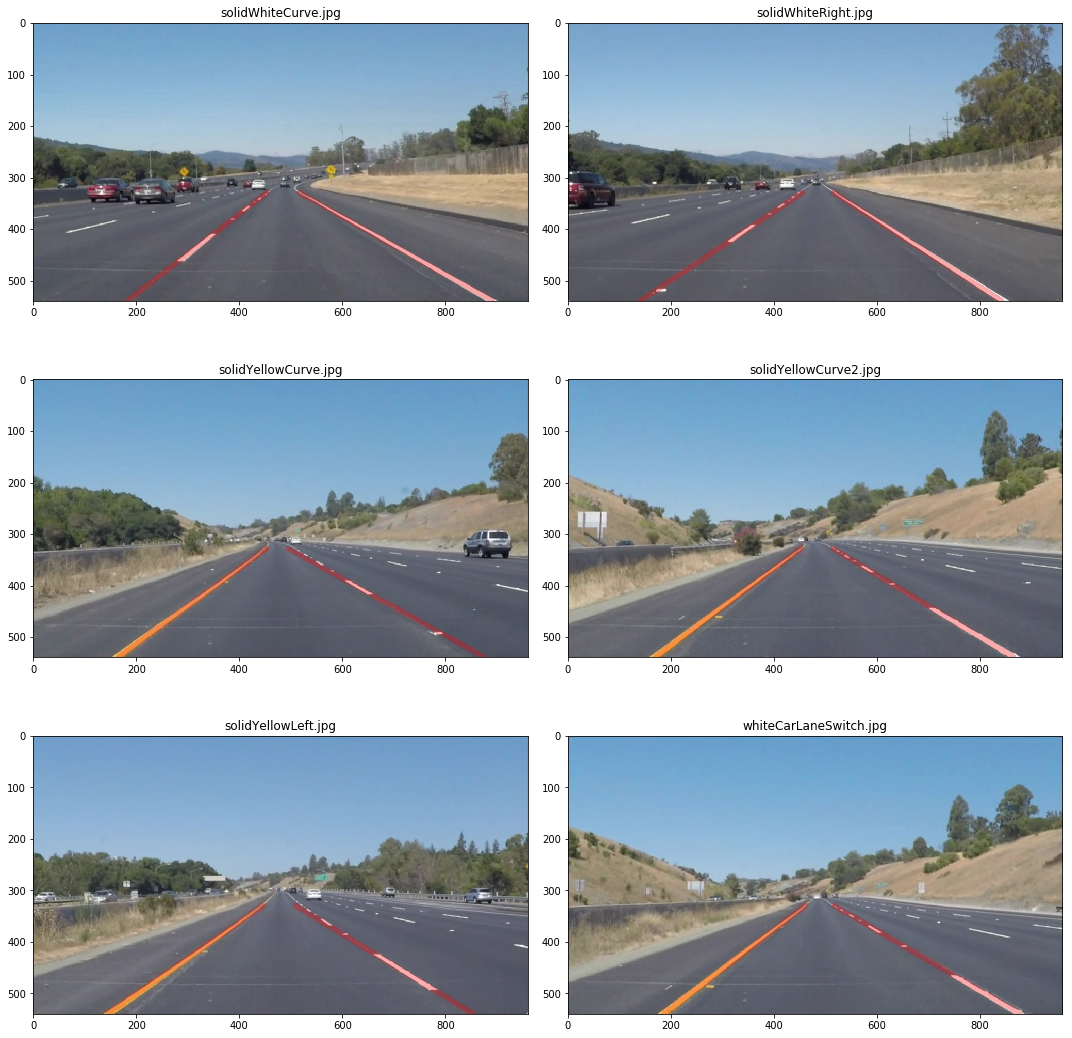

In [22]:
full_lane_drawn_images = list(map(lambda img, separated_lanes : trace_both_lane_lines(img, separated_lanes[0], separated_lanes[1]), 
                                  original_images, separated_lanes_per_image))
show_image_list(full_lane_drawn_images)

## Testing on Videos

A video is a sequence of frames. We can therefore use the information from previous frames to smoothen the lines that we trace on the road and take corrective steps if at frame t our computed lines differ disproportionately from the mean of line slopes and intercepts we computed from previous frames

In [23]:
from collections import deque

def create_lane_line_coefficients_list(length = 10):
    return deque(maxlen=length)

In [24]:
def trace_lane_line_with_coefficients(img, line_coefficients, top_y, make_copy=True):
    A = line_coefficients[0]
    b = line_coefficients[1]
    
    img_shape = img.shape
    bottom_y = img_shape[0] - 1
    # y = Ax + b, therefore x = (y - b) / A
    x_to_bottom_y = (bottom_y - b) / A
    
    top_x_to_y = (top_y - b) / A 
    
    new_lines = [[[int(x_to_bottom_y), int(bottom_y), int(top_x_to_y), int(top_y)]]]
    return draw_lines(img, new_lines, make_copy=make_copy)


def trace_both_lane_lines_with_lines_coefficients(img, left_line_coefficients, right_line_coefficients):
    vert = get_vertices_for_img(img)
    region_top_left = vert[0][1]
    
    full_left_lane_img = trace_lane_line_with_coefficients(img, left_line_coefficients, region_top_left[1], make_copy=True)
    full_left_right_lanes_img = trace_lane_line_with_coefficients(full_left_lane_img, right_line_coefficients, region_top_left[1], make_copy=False)
    
    # image1 * α + image2 * β + λ
    # image1 and image2 must be the same shape.
    img_with_lane_weight =  cv2.addWeighted(img, 0.7, full_left_right_lanes_img, 0.3, 0.0)
    
    return img_with_lane_weight

In [25]:
import math

MAXIMUM_SLOPE_DIFF = 0.1
MAXIMUM_INTERCEPT_DIFF = 50.0

class LaneDetectorWithMemory:
    def __init__(self):
        self.left_lane_coefficients  = create_lane_line_coefficients_list()
        self.right_lane_coefficients = create_lane_line_coefficients_list()
        
        self.previous_left_lane_coefficients = None
        self.previous_right_lane_coefficients = None
        
    
    def mean_coefficients(self, coefficients_queue, axis=0):        
        return [0, 0] if len(coefficients_queue) == 0 else np.mean(coefficients_queue, axis=axis)
    
    def determine_line_coefficients(self, stored_coefficients, current_coefficients):
        if len(stored_coefficients) == 0:
            stored_coefficients.append(current_coefficients) 
            return current_coefficients
        
        mean = self.mean_coefficients(stored_coefficients)
        abs_slope_diff = abs(current_coefficients[0] - mean[0])
        abs_intercept_diff = abs(current_coefficients[1] - mean[1])
        
        if abs_slope_diff > MAXIMUM_SLOPE_DIFF or abs_intercept_diff > MAXIMUM_INTERCEPT_DIFF:
            #print("Identified big difference in slope (", current_coefficients[0], " vs ", mean[0],
             #    ") or intercept (", current_coefficients[1], " vs ", mean[1], ")")
            
            # In this case use the mean
            return mean
        else:
            # Save our coefficients and returned a smoothened one
            stored_coefficients.append(current_coefficients)
            return self.mean_coefficients(stored_coefficients)
        

    def lane_detection_pipeline(self, img):
        combined_hsl_img = filter_img_hsl(img)
        grayscale_img = grayscale(combined_hsl_img)
        gaussian_smoothed_img = gaussian_blur(grayscale_img, kernel_size=5)
        canny_img = canny_edge_detector(gaussian_smoothed_img, 50, 150)
        segmented_img = region_of_interest(canny_img)
        hough_lines = hough_transform(segmented_img, rho, theta, threshold, min_line_length, max_line_gap)

        try:
            left_lane_lines, right_lane_lines = separate_lines(hough_lines, img)
            left_lane_slope, left_intercept = find_lane_lines_formula(left_lane_lines)
            right_lane_slope, right_intercept = find_lane_lines_formula(right_lane_lines)
            smoothed_left_lane_coefficients = self.determine_line_coefficients(self.left_lane_coefficients, [left_lane_slope, left_intercept])
            smoothed_right_lane_coefficients = self.determine_line_coefficients(self.right_lane_coefficients, [right_lane_slope, right_intercept])
            img_with_lane_lines = trace_both_lane_lines_with_lines_coefficients(img, smoothed_left_lane_coefficients, smoothed_right_lane_coefficients)
        
            return img_with_lane_lines

        except Exception as e:
            print("*** Error - will use saved coefficients ", e)
            smoothed_left_lane_coefficients = self.determine_line_coefficients(self.left_lane_coefficients, [0.0, 0.0])
            smoothed_right_lane_coefficients = self.determine_line_coefficients(self.right_lane_coefficients, [0.0, 0.0])
            img_with_lane_lines = trace_both_lane_lines_with_lines_coefficients(img, smoothed_left_lane_coefficients, smoothed_right_lane_coefficients)
        
            return img_with_lane_lines

Let's try the one with the solid white lane on the right first ...

In [26]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'test_videos_output/solidWhiteRight.mp4'
detector = LaneDetectorWithMemory()
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(detector.lane_detection_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 7.52 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [28]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')

detector = LaneDetectorWithMemory()
yellow_clip = clip2.fl_image(detector.lane_detection_pipeline)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 23.4 s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

In [30]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')

detector = LaneDetectorWithMemory()
challenge_clip = clip3.fl_image(detector.lane_detection_pipeline)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



t:  59%|███████████████████████████████████████▏                           | 147/251 [00:09<00:08, 12.66it/s, now=None]

*** Error - will use saved coefficients  Inputs must not be empty.


Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
Wall time: 19.2 s


In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

The current pipeline works quite nice even on the challenge video!